In [1]:
import os
import copy

import rospy
import rospkg
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from rosbag import Bag
from pathlib import Path

# The following import is temporary for coding purpose, change if there is error
from rosbag_read_utils.Rosbag_Reader import RosbagReader


class FormatConverter:
    def __init__(self) -> None:
        pass


def read_observations(obs_topic: str, rosbag: Bag):
    obs = pd.DataFrame(columns=["timestamp"] + [f"joint_{i}" for i in range(7)])

    # initialise progress bar
    pbar = tqdm(total=rosbag.get_message_count())

    for topic, msg, ts in rosbag.read_messages(obs_topic):
        pbar.update(1)
        timestamp = pd.to_datetime(ts.to_nsec(), unit="ns")
        obs.loc[len(obs)] = [timestamp] + [msg.position[0],
                                           msg.position[1],
                                           msg.position[2],
                                           msg.position[3],
                                           msg.position[4],
                                           msg.position[5],
                                           msg.position[6]] 
    # return the first 5 rows
    obs.head()

    return obs


def read_and_sync_image(obs: pd.DataFrame ,img_dir: str, img_topic: str, rosbag: Bag, bag_reader: RosbagReader):
    cv_image = []
    pbar = tqdm(total=rosbag.get_message_count())

    for idx, row in obs.iterrows():
        pbar.update(1)
        image = bag_reader.find_closest_image(rosbag, img_dir, img_topic, row["timestamp"])
        cv_image.append(image)
    return cv_image






In [2]:
ROS_BAG_PATH = os.path.abspath('') + "/../rosbag/2024-09-10-17-09-22.bag"
IMG_DIR = os.path.abspath('') + "/../image_data"
OBS_TOPIC = "/left_arm/joint_states"
IMG_TOPIC = "/left_arm_camera/color/image_rect_color"
# Initialise bag reader
bag_reader = RosbagReader()
bag = bag_reader.get_rosbag(path_to_bag=ROS_BAG_PATH)
# Read and sync robot obs and image data
obs = read_observations(OBS_TOPIC, bag)
cv_image = read_and_sync_image(obs, IMG_DIR, IMG_TOPIC, bag, bag_reader)

  0%|          | 0/4052 [00:00<?, ?it/s]

  1%|▏         | 58/4052 [00:11<13:01,  5.11it/s]

KeyboardInterrupt: 

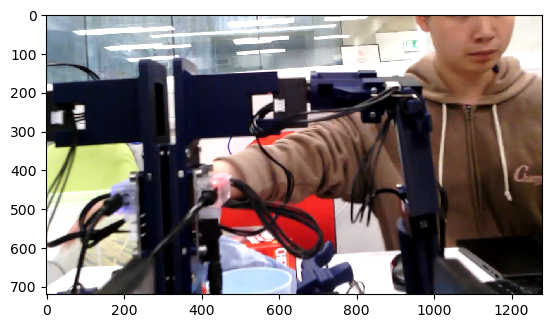

In [ ]:
# image playback
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation

# Create a figure to display the images
fig, ax = plt.subplots()

# Display the first image as the initial frame
im = ax.imshow(cv_image[0])

# Animation function
def update_frame(i):
    im.set_data(cv_image[i])
    return [im]

# Create an animation
ani = animation.FuncAnimation(fig, update_frame, frames=len(cv_image), interval=100)

# Show the animation in the notebook
plt.show()